In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
# %matplotlib notebook

In [2]:
file = "inputs/2022-11-23-12_13_44.csv"

In [3]:
df = pd.read_csv(file)
df.head()

,FRAME,KEY,STATUS
0,143,Key.enter,DOWN
1,145,Key.enter,UP
2,243,Key.enter,DOWN
3,246,Key.enter,UP
4,346,Key.right,DOWN


### Only keep keys that are of our interest

In [4]:
df_trim = df[(df['KEY'] == 'Key.left') | (df['KEY'] == 'Key.right') | (df['KEY'] == '\'d\'')]

df_trim.loc[(df_trim['KEY'] == 'Key.right') & (df_trim['STATUS'] == 'DOWN'), 'action'] = 'R'
df_trim.loc[(df_trim['KEY'] == 'Key.right') & (df_trim['STATUS'] == 'UP'), 'action'] = 'r'

df_trim.loc[(df_trim['KEY'] == 'Key.left') & (df_trim['STATUS'] == 'DOWN'), 'action'] = 'L'
df_trim.loc[(df_trim['KEY'] == 'Key.left') & (df_trim['STATUS'] == 'UP'), 'action'] = 'l'

df_trim.loc[(df_trim['KEY'] == '\'d\'') & (df_trim['STATUS'] == 'DOWN'), 'action'] = 'J'
df_trim.loc[(df_trim['KEY'] == '\'d\'') & (df_trim['STATUS'] == 'UP'), 'action'] = 'j'

df_trim

/tmp/ipykernel_753/4238722313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trim.loc[(df_trim['KEY'] == 'Key.right') & (df_trim['STATUS'] == 'DOWN'), 'action'] = 'R'


,FRAME,KEY,STATUS,action
4,346,Key.right,DOWN,R
5,491,'d',DOWN,J
6,517,'d',UP,j
7,519,Key.right,UP,r
8,534,Key.left,DOWN,L
...,...,...,...,...
2928,67243,'d',DOWN,J
2929,67301,'d',UP,j
2930,67356,'d',DOWN,J
2931,67363,'d',UP,j


In [5]:
df_trim = df_trim[["FRAME", "action"]]
df_trim

,FRAME,action
4,346,R
5,491,J
6,517,j
7,519,r
8,534,L
...,...,...
2928,67243,J
2929,67301,j
2930,67356,J
2931,67363,j


In [6]:
start = df_trim.FRAME.min()

# r, j, l
data = {"R": [], "L": [], "J": []}
r=0
l=0
j=0
for index, row in df_trim.iterrows():
    if row.action == "R".upper():
        data["R"].append([row.FRAME])
    if row.action == "R".lower():
        data["R"][-1].append(row.FRAME - data["R"][-1][0])
        
    if row.action == "L".upper():
        data["L"].append([row.FRAME])
    if row.action == "L".lower():
        data["L"][-1].append(row.FRAME - data["L"][-1][0])
        
    if row.action == "J".upper():
        data["J"].append([row.FRAME])
    if row.action == "J".lower():
        data["J"][-1].append(row.FRAME - data["J"][-1][0])

data

{'R': [[346, 173],
  [580, 71],
  [676, 58],
  [811, 21],
  [891, 108],
  [1173, 271],
  [1481, 6],
  [1533, 557],
  [2238, 190],
  [2474, 19],
  [2583, 32],
  [2721, 255],
  [2995, 22],
  [3027, 42],
  [3084, 75],
  [3173, 19],
  [3209, 666],
  [3884, 99],
  [4002, 49],
  [4467, 8],
  [4898, 82],
  [5171, 8],
  [5245, 132],
  [5408, 36],
  [5558, 83],
  [5718, 38],
  [5826, 354],
  [6304, 37],
  [6348, 50],
  [6430, 46],
  [6526, 42],
  [6619, 14],
  [6643, 86],
  [6969, 6],
  [7183, 147],
  [7357, 26],
  [7390, 13],
  [7442, 37],
  [7639, 51],
  [7743, 386],
  [8154, 8],
  [8222, 18],
  [8325, 16],
  [8367, 52],
  [8476, 43],
  [8544, 175],
  [8775, 16],
  [8885, 15],
  [8913, 71],
  [8990, 34],
  [9034, 14],
  [9099, 32],
  [9176, 9],
  [9197, 80],
  [9302, 29],
  [9345, 48],
  [9402, 95],
  [9506, 49],
  [9627, 132],
  [9847, 175],
  [10046, 28],
  [10112, 24],
  [10182, 177],
  [10387, 6],
  [10432, 113],
  [10918, 143],
  [11157, 23],
  [11215, 10],
  [11250, 31],
  [11306, 204],

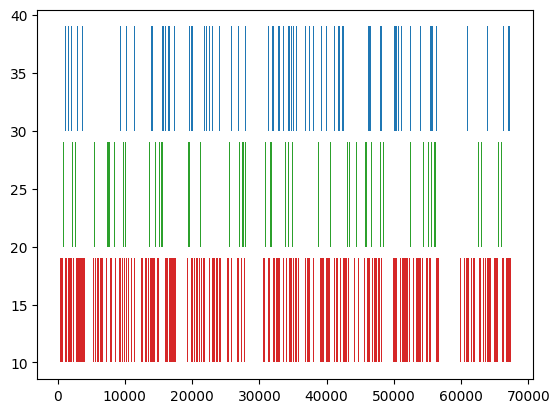

In [7]:
fig, ax = plt.subplots()
ax.broken_barh(data["R"], (10, 9), facecolors='tab:red')
ax.broken_barh(data["L"], (20, 9), facecolors='tab:green')
ax.broken_barh(data["J"], (30, 9), facecolors='tab:blue')
plt.show()

In [8]:
all_keys = ''.join(list(df_trim["action"]))
all_keys

'RJjrLlRJjrLlRJjrJLjJRljLrlLlRJjrLJjlRJjJjJjJjrLlRrLlRJjJjJjJjJjJjJjJjrLJjlRJjJjJjrRJjrLlRJjrLlLJjlRJjJjJjJjrRJjrRJjrRJjrJRjrRJjJjJjJjJjJjJjJjJjJjJjrRJjJjrRJjrRrRrRrRJjrLlJRjJjJjJjrLJjJjRlJjJjrRJjrRJjJjJjJjJjJjJjrLlLlRJjrRJjJjrLlRJjrRrLlRrRJjJjrRrRJjJjrLJlRjrRJjrLlRJjrLJjJjJjlRJjLrlJRjJjJjJjJjJjJjrLlRrLJljRrLlJjRrRrLRlJrLjlRJjJjrRrLlLlRrRJjrJRjrRrRrRrJRjJjJjJjJjrLlRJjrRJjrRJjJjrRLrlRJjrLlJjRJjJjJjJjrJLjlRrLlRJrLljRJjJjJjrJRjrRJjJjrRJjJjrLJjlJLjlLlRrJjRJrjRJrjJRjJjJjJjJjJjrLlRrLlRrRrRJjrRrRrRrRJjrRJjrLlJjLlLlJjRrJjLJjlJjRJjJjJjJjJjJjrJRjJjrRJjJjJjrLlLJjlRrRrRJjrLlRrRrRrLlJjRrRrRrJjRrJjLJljLlRrLJjlRrLlRJrjJRrjLlLlRrRJjJrjLlJLjlJjRrLlRrJRjrLlRJrjLlLlJjJjRJjJjrLlRJjJjrRrJjRrRrRJjJjJjJjrLlRJjJjJjrRJjrRJjJjrRrRrRrRrRrJjJjRrJjRrJjRrJjRrJjRrRrLlRrLJljLlRrRrRrLlRJjJjJrRjJjJjJjrJjRJjJjJjrLJjlJjRrLJljRJjrRJjJjJjJjrJjJRjrJRjJjJjrLRlrLRlrRJrjRJjrRJjrRrJjJjRrJjRrJjJjRJjJjrRJjrRrRrRrJjRrJjRJjrRJjJjrLlRrRJrjRrJRjrRrRJjJjJjJjrRrRJjJjJjJjJjrRJjJjrJjRrLlRrJRjrLlRJjJjJjLrRlrLlLlRJjrRJjJjJjrRrLlLlRJjJjrLlL

In [9]:
def getAllSubStrings(x, l=None, freq=False):
    if l == None:
        l = len(x)
    
    allSubStrings = [x[i:i+l] for i in range(0, len(x)) if len(x[i:i+l]) == l]

    if freq:
        return allSubStrings
    else:
        return set(allSubStrings)

In [10]:
def extract_freq(x, l=3, sort='value'):
    res = {}
    substrings = getAllSubStrings(all_keys, l=l, freq=True)
    for idx in substrings:
        if idx not in res.keys():
            res[idx] = 1
        else:
            res[idx] += 1
    if sort == 'key':
        return dict(sorted(res.items(), key=lambda item: item[0], reverse=False))
    elif sort == 'value':
        return dict(sorted(res.items(), key=lambda item: item[1], reverse=True))

In [11]:
extract_freq(all_keys, l=7, sort='value')

{'jJjJjJj': 62,
 'JjJjJjJ': 59,
 'JjJjJjr': 35,
 'RJjJjJj': 32,
 'jrLlRJj': 22,
 'JjJjrLl': 22,
 'JjrRJjr': 22,
 'JjrLlRJ': 21,
 'RJjrRJj': 20,
 'jJjJjrL': 19,
 'rLlRJjr': 18,
 'jrRJjJj': 18,
 'rRJjJjr': 17,
 'jJjrLlR': 16,
 'jJjrRJj': 16,
 'RJjJjrR': 16,
 'rRJjrLl': 15,
 'JjJjrRJ': 14,
 'jrRJjrR': 14,
 'rRJjJjJ': 14,
 'JjrRJjJ': 14,
 'RJjrLlR': 13,
 'LlRJjJj': 13,
 'JjJjrRr': 13,
 'JjRJjJj': 13,
 'lLlLlLl': 13,
 'LlRJjrL': 12,
 'lRJjJjJ': 12,
 'RJjJjrL': 12,
 'RrRJjJj': 12,
 'LlLlLlL': 12,
 'jJjJjrR': 11,
 'rRJjrRJ': 11,
 'RrRrRJj': 11,
 'rRrRJjr': 11,
 'lRJjrLl': 10,
 'JjrLJjl': 10,
 'RrRJjrL': 10,
 'rLlRJjJ': 9,
 'rRJjrRr': 9,
 'RJjrRrR': 9,
 'RrRrRrR': 9,
 'RJjrLlJ': 9,
 'JjrRrRJ': 9,
 'jrRrRJj': 9,
 'rRrRJjJ': 9,
 'jRJjJjJ': 9,
 'rJjRrJj': 9,
 'JjRrJjR': 9,
 'LJjlRJj': 8,
 'JjrLlRr': 8,
 'JjJjrLJ': 8,
 'rRrRrRJ': 8,
 'LlLlRJj': 8,
 'lRJjJjr': 8,
 'RJjrLJj': 7,
 'jlRJjJj': 7,
 'jJjrLJj': 7,
 'jrRJjrL': 7,
 'rRrRrRr': 7,
 'LlRJjrR': 7,
 'lRJjrRJ': 7,
 'LlRrRJj': 7,
 'JjrLlJj': 7,
 '

In [12]:
all_patterns = {}
for i in range(4, 11):
    all_patterns.update(extract_freq(all_keys, l=i, sort='value'))
all_patterns = dict(sorted(all_patterns.items(), key=lambda item: item[1], reverse=True))
all_patterns

{'JjJj': 193,
 'jJjJ': 117,
 'jJjJj': 110,
 'JjJjJ': 108,
 'JjJjJj': 101,
 'RJjr': 83,
 'rRJj': 75,
 'jJjr': 70,
 'RJjJ': 69,
 'JjrR': 68,
 'JjJjr': 68,
 'RJjJj': 65,
 'jJjJjJ': 65,
 'JjrL': 64,
 'jJjJjJj': 62,
 'JjJjJjJ': 59,
 'lRJj': 56,
 'JjJjJjJj': 56,
 'jrLl': 52,
 'rLlR': 51,
 'JjrLl': 48,
 'jrRJ': 47,
 'rRrR': 46,
 'LlRJ': 45,
 'RrRr': 43,
 'rRJjr': 43,
 'jrRJj': 42,
 'RrRJ': 39,
 'JjrRJ': 39,
 'LlRJj': 38,
 'RJjrR': 38,
 'jJjJjJjJ': 38,
 'jJjJjr': 37,
 'JjrRJj': 36,
 'RJjJjJ': 35,
 'JjJjJjr': 35,
 'JjJjJjJjJ': 35,
 'jJjJjJjJj': 35,
 'LlLl': 34,
 'RJjrL': 33,
 'jrLlR': 33,
 'rLlRJ': 33,
 'lRJjr': 33,
 'rRJjJ': 32,
 'RrRJj': 32,
 'RJjJjJj': 32,
 'JjJjJjJjJj': 32,
 'jrRr': 31,
 'jJjrL': 31,
 'JjJjrL': 31,
 'rRJjJj': 31,
 'LlRr': 30,
 'JjRr': 30,
 'jJjrR': 30,
 'RJjJjr': 30,
 'RrRrR': 29,
 'JjrLlR': 29,
 'RrJj': 28,
 'JjrRr': 28,
 'JjJjrR': 28,
 'RrLl': 27,
 'rLlRJj': 27,
 'RJjrLl': 26,
 'LJjl': 25,
 'rJjR': 25,
 'RJrj': 24,
 'jrLlRJ': 24,
 'LlRJjr': 24,
 'jrRJjr': 24,
 'JjlR': 23,

[('JjJj', 193), ('jJjJ', 117), ('jJjJj', 110), ('JjJjJ', 108), ('JjJjJj', 101), ('RJjr', 83), ('rRJj', 75), ('jJjr', 70), ('RJjJ', 69), ('JjrR', 68)]


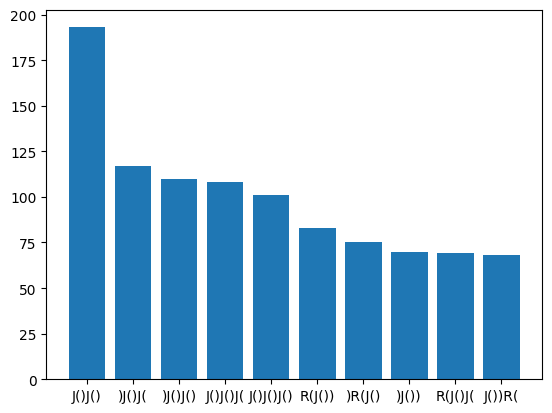

In [22]:
from itertools import islice
n_items = list(islice(all_patterns.items(), 10))
print(n_items)
keys = []
values = []
for i, (k, v) in enumerate(n_items):
    k = k.replace("J", "J(")
    k = k.replace("j", ")")
    k = k.replace("R", "R(")
    k = k.replace("r", ")")
    k = k.replace("L", "L(")
    k = k.replace("l", ")")
    keys.append(k)
    values.append(v)
    
fig, ax = plt.subplots()
ax.bar(keys, values)
plt.show()

In [ ]:
mapp = {"R": "Right", "r": "", "L": "Left", "l": "", "J": "Jump", "j": ""}
text = " ".join([mapp[k] for k in list(all_keys)])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
candidates = dict()
best_timeframe_size = 0

for second_tick in np.linspace(3, 10, 15): #3., 3.5, 4, ..., 9.5, 10.
    n_frame = second_tick*60
    slice_size = int(df_trim.FRAME.max()/n_frame)


    freq = pd.DataFrame(index=list_patterns_set[3], columns=['count', 'frequency'])
    freq['count'] = 0
    freq['frequency'] = 0

    for period in range(slice_size):
        slice = df_trim[(df_trim.FRAME >= period*n_frame) & (df_trim.FRAME < (period+1)*n_frame)]

        str = slice.action.str.cat()

        for item in freq.index:
            freq.loc[item, 'count'] += kmp(item, str)[1]

    n_pattern = freq['count'].sum()

    freq = freq.loc[freq['count'] > 0]    

    for item in freq.index:
        if n_pattern > 0:
            freq.loc[item, 'frequency'] = freq.loc[item, 'count']/n_pattern * 100
        else:
            freq.loc[item, 'frequency'] = 0

    candidates[second_tick] = freq.sort_values(by=['count'], ascending=False).head(15)

    print(second_tick, n_pattern)

list_patterns_set.append([''.join(item) for item in product(freq.index, 'RrLlJj')])
list_best_freq.append(candidates)
print(len(freq.index))
candidates